# Ant Rules

1. Ants lay pheromones when leaving the nest and returning to the nest with food
 1. More pheromones returning to nest
1. Ants can only move left or right when traversing forward or backward
 1. For example, when an ant is moving South East, it can only move to blocks directly east or south of its current location.
1. There is a max number of ants per point.
 1. If an ant can't move it must remain in its position
1. Fraction of pheromone evaporates at each time step
1. (Will's Rule) If ant finds food it switches direction (East -> West, South -> North, etc)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

from utils import decorate, savefig
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

In [97]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

def make_visible_locs(direction):
    """Computes the kernel of visible cells.
        
    direction: ant facing direction
    """
    if direction == "SE":
        return np.array([[-1, 0], [0, 1]])
    elif direction == "SW":
        return np.array([[-1, 0], [0, -1]])
    elif direction == "NW":
        return np.array([[1, 0], [0, -1]])
    else:
        return np.array([[1,0], [0,1]])
    
def flip_directions(direction):
    if direction == "NE":
        return "SW"
    elif direction == "NW":
        return "SE"
    elif direction == "SW":
        return "NE"
    else:
        return "NW"

In [120]:
class Antscape(Cell2D):
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        self.ant_per_cell_max = self.params.get('max_ants', 1)
        
        # initially all cells are empty
        self.array = self.make_food()
        
        # make the agents
        self.make_agents()
        
    
    def make_food(self):
        
        array = np.zeros([self.n, self.n])
        x, y = 10, 10
        for i in range(x):
            for j in range(y):
                array[60 + i, 60 + j] = 1
        return array

        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        loc = (0,0)

        # make the agents
        num_agents = self.params.get('num_agents', 20)
        self.agents = [Agent(loc, self.params) 
                       for i in range(num_agents)]
        
        # keep track of which cells are occupied
        self.occupied = [agent.loc for agent in self.agents]
            
    def find_food(self, center):
        
        return self.array[center] == 1
        
    def look_and_move(self, center, direction):
        
        # find all cells fly can move to
        locs = make_visible_locs(direction)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        #calc number of ants in each cell
        num_ants = {}
        for loc in locs:
            count = 0
            for xy in self.occupied:
                if xy == loc:
                    count += 1
            num_ants[loc] = count
        
        # select cells that are not too full
        empty_locs = [loc for loc in locs if num_ants[loc] < self.ant_per_cell_max]

        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        i = np.random.randint(0, len(empty_locs))
        
        return empty_locs[i]
            
        
    def step(self):
        """Executes one time step."""
        
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)
            
            #mark fly's new cell as occupied
            self.occupied.append(agent.loc)
        
        return len(self.agents)
    
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Blues', vmax=2, origin='lower')
        
        # draw occupied cells
        xs, ys = self.get_coords(self.occupied)
        self.points = plt.plot(xs, ys, '.', color='black')[0]
    
    def get_coords(self, locs):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        locs = list(locs)
        rows, cols = np.transpose(locs)
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

In [96]:
class Agent:
    
    def __init__(self, loc, params):

        self.loc = tuple(loc)
        self.has_food = False
        self.direction = "NE"
        # extract the parameters
#         self.max_clock = params.get('max_clock', 10)
#         self.move_vis = params.get('max_move', 1)
#         self.lit_vis = params.get('max_lit_vis', 1)
#         self.react = params.get('react', 1)
        
    

    def step(self, env):
        
        found_food = env.find_food(self.loc)
        
        if found_food and not self.has_food:
            self.direction = flip_directions(self.direction)
            self.has_food = True
        
        #move agent
        self.loc = env.look_and_move(self.loc, self.direction)
                                                      



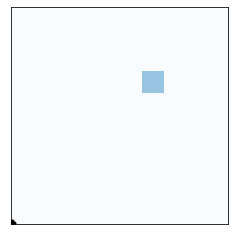

In [127]:
env = Antscape(100, num_agents=200)


env.step()
env.draw()

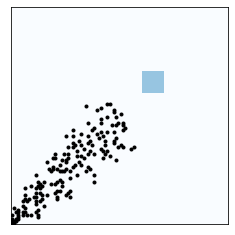

In [128]:
env.animate(frames=100, interval=.05)